# Relative motion estimation between 2 frames

## 1. Import libraries vs. images

In [1]:
import matplotlib.pyplot as plt
from utils import *
import cv2
import json
import numpy as np

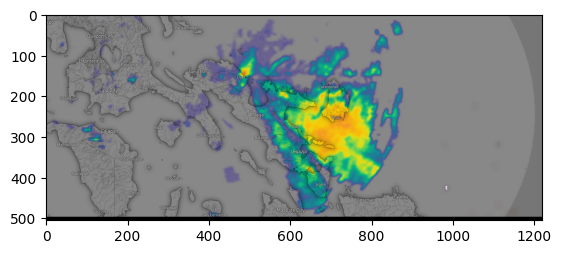

In [2]:
img_paths = [
    'data/image_old/japan_20250108-031044.png',
    'data/image_old/japan_20250108-031644.png',
    'data/image_old/japan_20250108-032245.png',
    'data/image_old/japan_20250108-032845.png',
]
color_path = 'data/legend/color_dbz.json'

with open('data/legend/color_dbz.json') as f:
    list_color = json.load(f)

sorted_color = sorted({tuple(color[1]): color[0] for color in list_color}.items(), key=lambda item: item[1])

src_images = [read_image(path) for path in img_paths]
plt.imshow(src_images[0])
plt.show()

## 2. Identification

- Extract the contours

- Simplify the contours using Douglas-Peucker algorithm

- Extract point descriptors

### 2.1 Extract the contours

| Variable | Description |
| --- | --- |
| *contours_time* | a list of *contours_dbz* set in vary of time. |
| *contours_dbz* | a list of *contours* set in vary of DBz. |
| *contours* | a list of *contour* of a dbz in a specific time. |
| *contour* | a list of *points* which is of shape (1, 2). |

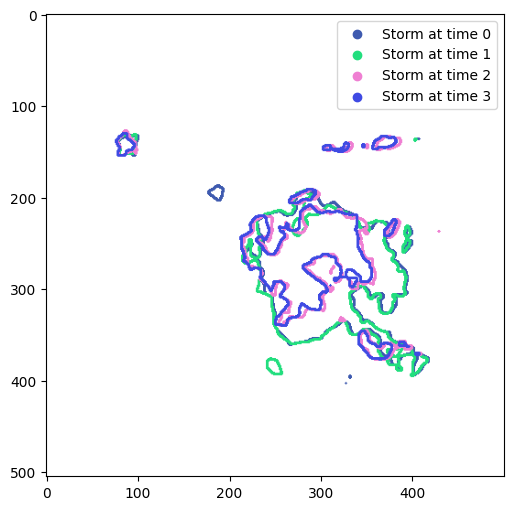

In [3]:
contours_time = [extract_contour_by_dbz(img, thresholds=[35], sorted_color=sorted_color)[1] for img in src_images]
num_of_contours = len(contours_time)

# Plot contours
plt.figure(figsize=(6, 6))

blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255
np.random.seed(2025)
color_set = np.random.randint(0, 256, size=(num_of_contours, 3), dtype=np.uint8)

for i, (contours_dbz, color) in enumerate(zip(contours_time, color_set)):
    color = tuple(int(c) for c in color)
    scaled_color = tuple(c / 255.0 for c in color)

    cv2.drawContours(blank_img, contours=contours_dbz[0], contourIdx=-1, thickness=2, color=color)
    plt.scatter([], [], c=[scaled_color], label=f"Storm at time {i}")

plt.imshow(blank_img[:, 400:900])
plt.legend()
plt.show()

### 2.2 Simplify contours

Number of polygons in time 1 before simplifying: 6
Number of polygons in time 1 after simplifying: 6


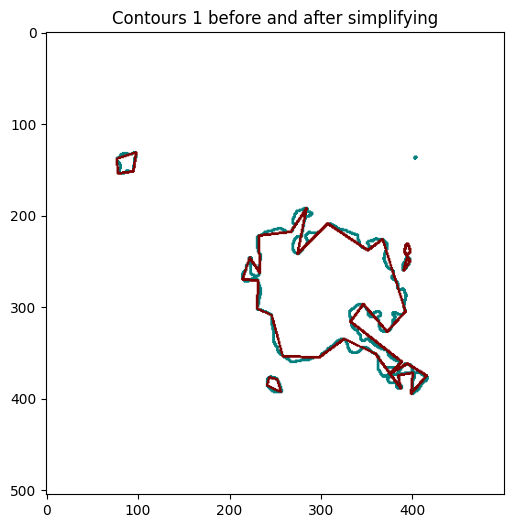

In [4]:
polygons_time = [process_contours(contours_dbz[0]) for contours_dbz in contours_time]

plt.figure(figsize=(6, 6))
# plt.subplot(1, 2, 1)
idx = 1
contours = contours_time[idx][0]
simplified_contours = polygons_to_contours(polygons_time[idx])

print(f"Number of polygons in time {idx} before simplifying: {len(contours)}")
print(f"Number of polygons in time {idx} after simplifying: {len(simplified_contours)}")


blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255
cv2.drawContours(blank_img, contours, -1, color=(0, 127, 127), thickness=2)
cv2.drawContours(blank_img, simplified_contours, -1, color=(127, 0, 0), thickness=2)

plt.title(f"Contours {idx} before and after simplifying")
plt.imshow(blank_img[:, 400:900])
plt.show()

### 2.3 Extract vector shape features

In [5]:
point_features = []
radii = [20, 60, 100, 200]
num_sectors = 8

shape_vectors_time = []

for idx, polygons in enumerate(polygons_time):
    shape_vectors = []
    for polygon in polygons:
        shape_vectors.append([    # since point has shape (1, 2)
            ShapeVector(point, construct_shape_vector(polygons, point, radii, num_sectors)) \
            for point in list(polygon.exterior.coords)
        ])

    shape_vectors_time.append(shape_vectors)

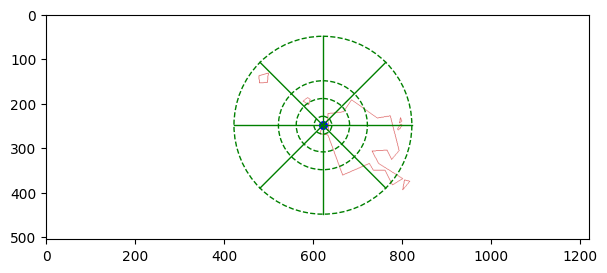

In [36]:
time = 0
pol_idx = 0
vertex_idx = 2

shape_vector = shape_vectors_time[time][pol_idx][vertex_idx]
point = shape_vector.coord
vector = shape_vector.vector
contours = polygons_to_contours(polygons_time[time])

def plot_shape_vector(contours, point_A, radii, num_sectors):
    plt.figure(figsize=(7, 7))
    fig = plt.gcf()
    ax = fig.gca()

    blank_img = np.ones_like(src_images[0], dtype=np.int16) * 255

    # Plot polygon (assuming you have a helper function plot_contour)
    cv2.drawContours(blank_img, contours, -1, color=(200,0,0), thickness=1)

    # Add circles
    for r in radii:
        circle = plt.Circle(point_A, radius=r, color='green', fill=False, linestyle="--")
        ax.add_patch(circle)

    # Add radial lines (sectors)
    longest_r = max(radii)
    for i in range(num_sectors):
        grad_angle = np.deg2rad(i * (360 / num_sectors))
        x_start, y_start = point_A
        x_end = x_start + np.cos(grad_angle) * longest_r
        y_end = y_start + np.sin(grad_angle) * longest_r
        plt.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=1)

    # Mark the reference point
    plt.scatter([point_A[0]], [point_A[1]], marker='o', s=30, color="blue", label="Point A")

    plt.imshow(blank_img)
    plt.show()

plot_shape_vector(contours, point, radii, num_sectors)

## 3. Model evaluating

In [ ]:
# compute_overlapping(
#     polygons_time[0],
#     polygons_time[1]
# )

array([[0.9059917 , 0.01004163, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.87694806, 0.        , 0.        ,
        0.        ],
       [0.        , 0.7332993 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.4193381 ],
       [0.        , 0.        , 0.        , 0.        , 0.4543956 ,
        0.        ]], dtype=float32)

In [ ]:
from typing import List, Tuple
import math

def _compute_similarity_pair(svector_1: ShapeVector, svector_2: ShapeVector, circle_area: float):
    return np.sum(np.abs(svector_1.vector - svector_2.vector)) / circle_area

def _estimate_movement(
        movements: Tuple[]
    ):
    

def compute_movement(
        shape_polygon_1: List[ShapeVector], 
        shape_polygon_2: List[ShapeVector], 
        circle_area: float, 
        threshold: float = 0.05
    ) -> Tuple[Tuple[float, float], float]:
    valid_pairs = []
    for svector_1 in shape_polygon_1:
        for svector_2 in shape_polygon_2:
            score = _compute_similarity_pair(svector_1, svector_2, circle_area)
            if score < threshold:
                valid_pairs.append((score, (svector_1.coord, svector_2.coord)))
    
    return valid_pairs

def compute_distance(v1: ShapeVector, v2: ShapeVector) -> float:
    x1, y1 = v1.coord
    x2, y2 = v2.coord

    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

Best score: 0.057986265523953986
Best pair:
	(633.0, 263.0)	(614.0, 250.0)


In [ ]:
r = radii[-1]
circle_area = r * r * np.pi

prev = 1
curr = 2

shape_vectors_prev = shape_vectors_time[prev]
shape_vectors_curr = shape_vectors_time[curr]

displacement_lists = []

for pol_1 in shape_vectors_prev:
    best_score = float("inf")
    best_pair = None
    for pol_2 in shape_vectors_curr:
        score, pair = compute_similarity_polyon(pol_1, pol_2, circle_area, threshold=0.01)
        displacement = compute_distance
        if score < best_score:
            best_score = score
            best_pair = pair
    print()

	1.		2.		3.		4.		5.		6.		7.		8.	
1.	0.058 - 23.02	0.060 - 16.03	0.124 - 176.58	0.113 - 80.75	0.072 - 12.17	0.063 - 15.81	0.104 - 62.03	0.065 - 26.42	
2.	0.118 - 76.54	0.050 - 30.00	0.136 - 411.20	0.187 - 241.75	0.176 - 137.36	0.210 - 213.85	0.204 - 246.68	0.149 - 97.08	
3.	0.071 - 159.40	0.087 - 393.97	0.009 - 29.83	0.076 - 309.01	0.095 - 311.49	0.091 - 201.14	0.091 - 228.18	0.094 - 281.57	
4.	0.091 - 40.01	0.176 - 97.05	0.149 - 294.68	0.208 - 278.37	0.224 - 197.65	0.223 - 191.61	0.221 - 247.42	0.170 - 95.00	
5.	0.083 - 48.70	0.186 - 118.53	0.150 - 322.57	0.128 - 86.49	0.062 - 15.26	0.138 - 100.66	0.147 - 104.02	0.178 - 97.08	
6.	0.085 - 53.31	0.158 - 93.94	0.150 - 328.90	0.142 - 100.28	0.062 - 15.00	0.154 - 107.78	0.168 - 115.68	0.154 - 85.87	


In [46]:
def compute_similarity_frame(
        shape_vectors_1: List[ShapeVector], 
        shape_vectors_2: List[ShapeVector], 
        circle_area: float, 
        threshold: float = 0.1
    ) -> List[Tuple[Tuple[ShapeVector, ShapeVector], float]]:
    valid_pairs = []

    for svector_1 in shape_vectors_1:
        for svector_2 in shape_vectors_2:
            score = _compute_similarity_pair(svector_1, svector_2, circle_area)
            if score < threshold:
                valid_pairs.append(((svector_1, svector_2), score))
    
    return valid_pairs

shape_vectors_1 = [shape_vector for shape_vectors in shape_vectors_time[0] for shape_vector in shape_vectors]
shape_vectors_2 = [shape_vector for shape_vectors in shape_vectors_time[1] for shape_vector in shape_vectors]
print(f"Number of shape_vectors in frame 1: {len(shape_vectors_1)}")
print(f"Number of shape_vectors in frame 2: {len(shape_vectors_2)}")

valid_pairs = compute_similarity_frame(shape_vectors_1, shape_vectors_2, circle_area, threshold=0.01)
print(f"Number of valid pairs: {len(valid_pairs)}")

def compute_displacement(v1: ShapeVector, v2: ShapeVector) -> Tuple[float, float]:
    return tuple(val2 - val1 for val1, val2 in zip(v1.coord, v2.coord))

distances = [compute_distance(pair[0][0], pair[0][1]) for pair in valid_pairs]
displacements = [compute_displacement(pair[0][0], pair[0][1]) for pair in valid_pairs]
for dist, disp in zip(distances, displacements):
    print(disp, "\t", dist)

Number of shape_vectors in frame 1: 58
Number of shape_vectors in frame 2: 63
Number of valid pairs: 19
(-1.0, -1.0) 	 1.4142135623730951
(-1.0, -1.0) 	 1.4142135623730951
(-1.0, 0.0) 	 1.0
(0.0, 16.0) 	 16.0
(19.0, -23.0) 	 29.832867780352597
(-2.0, -16.0) 	 16.1245154965971
(-1.0, 0.0) 	 1.0
(19.0, -23.0) 	 29.832867780352597
(-2.0, -1.0) 	 2.23606797749979
(-1.0, -1.0) 	 1.4142135623730951
(-1.0, -1.0) 	 1.4142135623730951
(-2.0, 0.0) 	 2.0
(-2.0, 0.0) 	 2.0
(-4.0, 4.0) 	 5.656854249492381
(0.0, 2.0) 	 2.0
(-1.0, 1.0) 	 1.4142135623730951
(-4.0, 4.0) 	 5.656854249492381
(0.0, 2.0) 	 2.0
(-1.0, 1.0) 	 1.4142135623730951
